### Exercise 1

You've just been hired at a wine company and they would like you to help them build a model that predicts the quality of their wine based on several measurements. They give you a dataset with wine

- Load the ../data/wines.csv into Pandas
- Use the column called "Class" as target
- Check how many classes are there in target, and if necessary use dummy columns for a multi-class classification
- Use all the other columns as features, check their range and distribution (using seaborn pairplot)
- Rescale all the features using either MinMaxScaler or StandardScaler
- Build a deep model with at least 1 hidden layer to classify the data
- Choose the cost function, what will you use? Mean Squared Error? Binary Cross-Entropy? Categorical Cross-Entropy?
- Choose an optimizer
- Choose a value for the learning rate, you may want to try with several values
- Choose a batch size
- Train your model on all the data using a `validation_split=0.2`. Can you converge to 100% validation accuracy?
- What's the minumum number of epochs to converge?
- Repeat the training several times to verify how stable your results are

In [124]:
import pandas as pd
from pandas.tools.plotting import scatter_matrix as smplot
import numpy as np
import sklearn 
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

from sklearn.metrics import r2_score, accuracy_score, precision_score, f1_score, zero_one_loss, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate, KFold, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler as SS

import scipy

% matplotlib inline

## Import Data

In [3]:
df = pd.read_csv('../data/wines.csv')
df.head()

,Class,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280-OD315_of_diluted_wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


## Overview of Data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
Class                           178 non-null int64
Alcohol                         178 non-null float64
Malic_acid                      178 non-null float64
Ash                             178 non-null float64
Alcalinity_of_ash               178 non-null float64
Magnesium                       178 non-null int64
Total_phenols                   178 non-null float64
Flavanoids                      178 non-null float64
Nonflavanoid_phenols            178 non-null float64
Proanthocyanins                 178 non-null float64
Color_intensity                 178 non-null float64
Hue                             178 non-null float64
OD280-OD315_of_diluted_wines    178 non-null float64
Proline                         178 non-null int64
dtypes: float64(11), int64(3)
memory usage: 19.5 KB


In [5]:
df.describe()

,Class,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280-OD315_of_diluted_wines,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


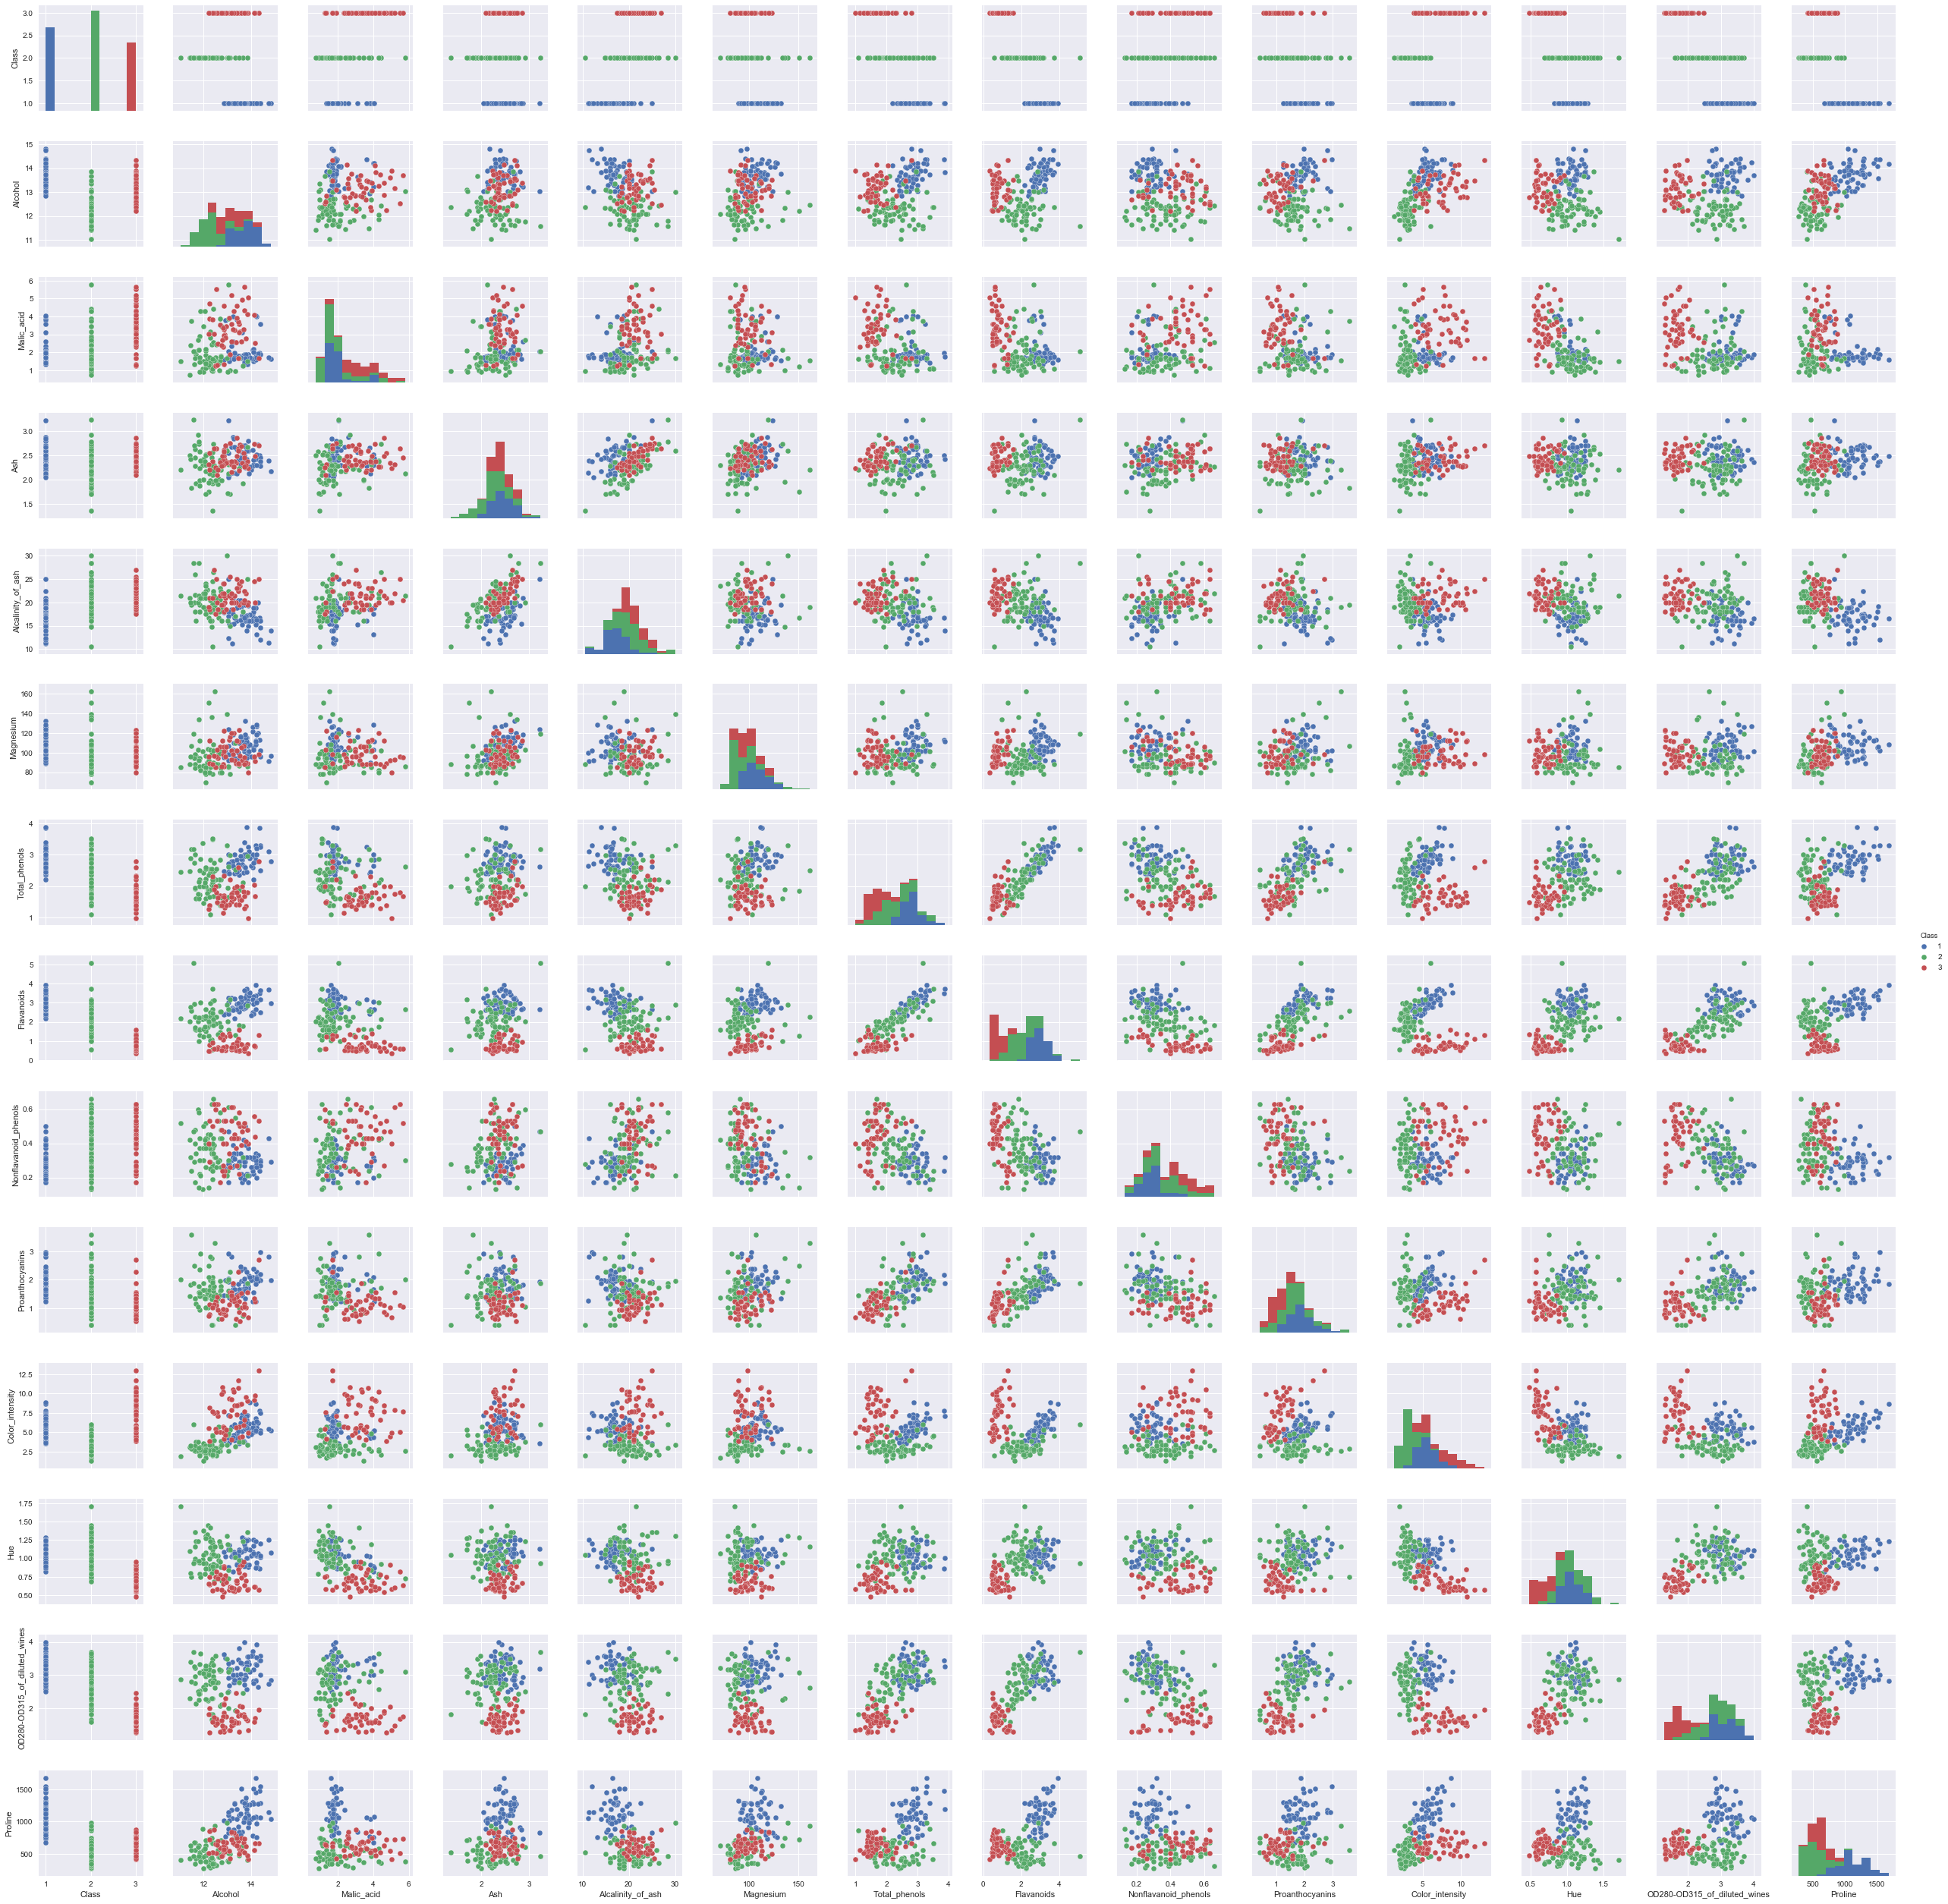

In [6]:
sns.pairplot(df, hue='Class')

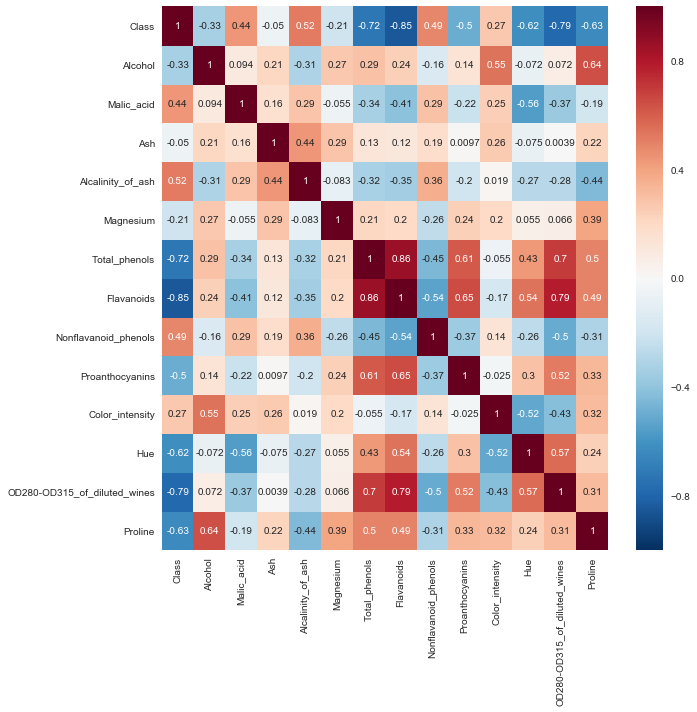

In [9]:
corr = df.corr()
fig, ax = plt.subplots(figsize=[10,10])
sns.heatmap(corr, ax=ax, annot = True)

In [85]:
X = df.iloc[:,:-1].values
y = pd.get_dummies(df.Class).values
# y = pd.get_dummies(df.Class).iloc[:,:2].values

## Feature Normalization

In [12]:
ss = SS()
Xs = ss.fit_transform(X)

## Dimension Reduction by PCA

In [13]:
stopping_variance = 0.99 # stopping criteria
for n_comps in range(Xs.shape[1], 0, -1):
    pca = PCA(n_components = n_comps)
    pca.fit(Xs)
    if sum(pca.explained_variance_ratio_) >= stopping_variance:
        pca_sv = pca
    
    print('======================== ', n_comps, ' components =========================')
    print('================== explained variance ratio: =========================')
    print(pca.explained_variance_ratio_)
    print('\n')
    print("total variance explained: {:0.3f}".format(sum(pca.explained_variance_ratio_)))
    print('\n')

========================  13  components =========================
================== explained variance ratio: =========================
[ 0.3996507   0.16770494  0.10920338  0.0683296   0.06528109  0.05148865
  0.04248671  0.02680753  0.02028839  0.01995798  0.01304329  0.01042324
  0.00533449]


total variance explained: 1.000


========================  12  components =========================
================== explained variance ratio: =========================
[ 0.3996507   0.16770494  0.10920338  0.0683296   0.06528109  0.05148865
  0.04248671  0.02680753  0.02028839  0.01995798  0.01304329  0.01042324]


total variance explained: 0.995


========================  11  components =========================
================== explained variance ratio: =========================
[ 0.3996507   0.16770494  0.10920338  0.0683296   0.06528109  0.05148865
  0.04248671  0.02680753  0.02028839  0.01995798  0.01304329]


total variance explained: 0.984


========================  10  compon

In [15]:
pd.DataFrame(pca_sv.components_, columns=df.columns[1:]) 

,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280-OD315_of_diluted_wines,Proline
0,0.400618,-0.100494,0.241781,0.018240,0.222301,-0.107407,-0.367903,-0.404844,0.278716,-0.289546,0.131887,-0.301137,-0.375250
1,-0.042790,0.512530,0.222820,0.371094,0.006439,0.354651,0.159320,0.089444,-0.027556,0.131578,0.540187,-0.266302,-0.090162
2,0.007086,-0.272252,0.052529,0.603569,0.622288,0.081183,0.103092,0.118075,0.209387,0.098088,-0.208475,0.134374,0.159340
3,0.030809,-0.080731,-0.468366,0.093058,-0.046850,0.714827,-0.212779,-0.164111,-0.119993,-0.228026,-0.032345,0.253683,-0.217558
4,0.211901,-0.353198,0.283643,-0.252996,0.162204,0.342441,-0.003944,-0.001670,-0.517095,0.393786,-0.095369,-0.330512,0.038813
5,0.219323,-0.190119,-0.561312,-0.134623,0.114743,-0.149000,0.139866,0.055868,0.238366,0.510288,0.400036,-0.040365,-0.213630
6,-0.072688,-0.055755,0.371387,-0.153182,-0.290906,0.344075,-0.030977,-0.062393,0.621380,0.395211,-0.179775,0.205120,-0.075170
7,0.076851,0.494084,0.083279,-0.177971,0.396754,-0.113571,-0.327953,-0.160847,-0.207813,0.314430,-0.026651,0.511229,-0.059249
8,0.274345,-0.141438,0.283809,-0.188347,0.083741,0.036136,0.566465,0.147601,-0.077932,-0.296188,0.197752,0.462347,-0.301744
9,0.033626,0.289871,-0.158125,-0.494162,0.413081,0.256597,0.257117,-0.044077,0.300917,-0.224784,-0.101439,-0.247122,0.358716


In [ ]:
Xs = pca_sv.transform(Xs)

## Train-test Split

In [86]:
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2)

## DNN

In [111]:
def CreateDNNModel(input_dim, opt=Adam(lr=0.1), lossfunc = 'binary_crossentropy', metrics = None,
                   hidden_nodes=[1], activators = ['sigmoid'], reg=None, ini='he_normal', verbose=1):

    model = Sequential()
    NNlayout = zip(hidden_nodes, activators)
    for i_layer, layerparam in enumerate(NNlayout):
        if i_layer == 0:
            model.add(Dense(layerparam[0], input_dim=input_dim, kernel_initializer = ini, kernel_regularizer = reg))
        else:
            model.add(Dense(layerparam[0], kernel_initializer = ini, kernel_regularizer = reg))
        model.add(Activation(layerparam[1]))
    if verbose:
        print(model.summary())    
    model.compile(optimizer = opt, loss = lossfunc, metrics=metrics)

    return model

In [131]:
myepos = 100
myreg = l2(0.01)
myhidden_nodes=[5, y.shape[1]]
myopt = RMSprop(lr=0.1)
myactivators = ['tanh','softmax']
mymetrics = ['accuracy']
myloss = 'categorical_crossentropy'

model = CreateDNNModel(Xs_train.shape[1],
                       reg=myreg, 
                       hidden_nodes = myhidden_nodes, 
                       opt=myopt, 
                       activators=myactivators, 
                       metrics = mymetrics,
                       lossfunc = myloss)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 5)                 70        
_________________________________________________________________
activation_13 (Activation)   (None, 5)                 0         
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 18        
_________________________________________________________________
activation_14 (Activation)   (None, 3)                 0         
Total params: 88
Trainable params: 88
Non-trainable params: 0
_________________________________________________________________
None


### view result: precision, recall and f1-score

In [132]:
model.fit(Xs_train, y_train, batch_size=64, epochs=myepos, verbose=0)
y_train_pred = model.predict(Xs_train)
#### need to convert output for softmax !!!
# y_train_pred = np.array([[1,0] if y1>y2 else [0,1] for [y1, y2] in y_train_pred])

In [95]:
# print(classification_report(y_train, y_train_pred))

### accuracy and zero-one-loss

In [133]:
score = model.evaluate(Xs_test, y_test, batch_size=64)
score

36/36 [==============================] - 0s


[0.21645140647888184, 1.0]

## Run variant DNNs

In [99]:
A = Xs_train
B = Xs_test
C = y_train
D = y_test

### get configurations in dataframe

In [100]:
def ConfLayout(num_layers, num_nodes, output_nodes, activators):
    layoutconf = {}
    for n_layers in num_layers:
        
        last_layer_nodes = [output_nodes]
        output_activator = 'sigmoid' if output_nodes==1 else 'softmax'
        
        if n_layers == 0: # logistic regression
            layoutconf[n_layer] = np.array(last_layer_nodes.reverse())
            Activator = [output_activator]
            
        else: # at least one layer NN
            for i_layer in range(1,n_layers+1):
                if i_layer == 1:
                    last_layer_nodes = last_layer_nodes * len(num_nodes)
                    last_layer_nodes = [last_layer_nodes] + [num_nodes]
                else:
                    last_layer_nodes = [i*len(num_nodes) for i in last_layer_nodes]
                    curr_layer_nodes = [val for val in num_nodes for _ in range(len(num_nodes)**(i_layer-1))]
                    last_layer_nodes.append(curr_layer_nodes)
            
            Activator = [[i]*n_layers for i in activators]
        
        for i in range(len(Activator)):
            Activator[i].append(output_activator)
            
        last_layer_nodes.reverse()
        
        layoutconf[n_layers] = {'layerconf': np.array(last_layer_nodes),
                               'activatorconf': Activator}
        
    return layoutconf

In [101]:
num_layer_opts = [1, 2, 3,]
num_node_opts = [5, 10, 20]
output_nodes = B.shape[1]
activator_opts = ['relu']
batch_sizes = [32, 64, 256]
myepos = 200
myopts = ['SGD(lr=0.01)', 
          'Adam(lr=0.01)',
          'Adagrad(lr=0.01)',
          'RMSprop(lr=0.01)']
myregs = ['l2(0.1)',
          'l2(0.01)',
          'l2(0.001)']
myinis = ['uniform', 'normal',
          'he_normal', 'lecun_uniform'] 

layerconfigall = ConfLayout(num_layer_opts, num_node_opts, output_nodes, activator_opts)

In [103]:
D = []
for nlayer in num_layer_opts:
    for myactivators in layerconfigall[nlayer]['activatorconf']:
        for i in range(layerconfigall[nlayer]['layerconf'].shape[1]):
            myhidden_nodes = layerconfigall[nlayer]['layerconf'][:,i].tolist()
            for myreg in myregs:  
                for myopt in myopts:
                    for myini in myinis:
                        for mybatchsize in batch_sizes:

                            d = {'nlayers':nlayer,'layers':myhidden_nodes,'activators':myactivators,
                                 'ini': myini,
                                 'reg': myreg,
                                 'opt': myopt,
                                 'batch_size': mybatchsize}
                            D.append(d)
                            print(d)
               
pd.DataFrame(D, columns=['nlayers','layers','activators','ini',
                         'reg','opt','batch_size']).to_csv('Ex2_cv_configs.csv')

{'layers': [5, 13], 'batch_size': 32, 'opt': 'SGD(lr=0.01)', 'ini': 'uniform', 'nlayers': 1, 'reg': 'l2(0.1)', 'activators': ['relu', 'softmax']}
{'layers': [5, 13], 'batch_size': 64, 'opt': 'SGD(lr=0.01)', 'ini': 'uniform', 'nlayers': 1, 'reg': 'l2(0.1)', 'activators': ['relu', 'softmax']}
{'layers': [5, 13], 'batch_size': 256, 'opt': 'SGD(lr=0.01)', 'ini': 'uniform', 'nlayers': 1, 'reg': 'l2(0.1)', 'activators': ['relu', 'softmax']}
{'layers': [5, 13], 'batch_size': 32, 'opt': 'SGD(lr=0.01)', 'ini': 'normal', 'nlayers': 1, 'reg': 'l2(0.1)', 'activators': ['relu', 'softmax']}
{'layers': [5, 13], 'batch_size': 64, 'opt': 'SGD(lr=0.01)', 'ini': 'normal', 'nlayers': 1, 'reg': 'l2(0.1)', 'activators': ['relu', 'softmax']}
{'layers': [5, 13], 'batch_size': 256, 'opt': 'SGD(lr=0.01)', 'ini': 'normal', 'nlayers': 1, 'reg': 'l2(0.1)', 'activators': ['relu', 'softmax']}
{'layers': [5, 13], 'batch_size': 32, 'opt': 'SGD(lr=0.01)', 'ini': 'he_normal', 'nlayers': 1, 'reg': 'l2(0.1)', 'activators'

{'layers': [5, 5, 10, 13], 'batch_size': 32, 'opt': 'SGD(lr=0.01)', 'ini': 'he_normal', 'nlayers': 3, 'reg': 'l2(0.1)', 'activators': ['relu', 'relu', 'relu', 'softmax']}
{'layers': [5, 5, 10, 13], 'batch_size': 64, 'opt': 'SGD(lr=0.01)', 'ini': 'he_normal', 'nlayers': 3, 'reg': 'l2(0.1)', 'activators': ['relu', 'relu', 'relu', 'softmax']}
{'layers': [5, 5, 10, 13], 'batch_size': 256, 'opt': 'SGD(lr=0.01)', 'ini': 'he_normal', 'nlayers': 3, 'reg': 'l2(0.1)', 'activators': ['relu', 'relu', 'relu', 'softmax']}
{'layers': [5, 5, 10, 13], 'batch_size': 32, 'opt': 'SGD(lr=0.01)', 'ini': 'lecun_uniform', 'nlayers': 3, 'reg': 'l2(0.1)', 'activators': ['relu', 'relu', 'relu', 'softmax']}
{'layers': [5, 5, 10, 13], 'batch_size': 64, 'opt': 'SGD(lr=0.01)', 'ini': 'lecun_uniform', 'nlayers': 3, 'reg': 'l2(0.1)', 'activators': ['relu', 'relu', 'relu', 'softmax']}
{'layers': [5, 5, 10, 13], 'batch_size': 256, 'opt': 'SGD(lr=0.01)', 'ini': 'lecun_uniform', 'nlayers': 3, 'reg': 'l2(0.1)', 'activators

{'layers': [20, 5, 5, 13], 'batch_size': 32, 'opt': 'Adagrad(lr=0.01)', 'ini': 'uniform', 'nlayers': 3, 'reg': 'l2(0.001)', 'activators': ['relu', 'relu', 'relu', 'softmax']}
{'layers': [20, 5, 5, 13], 'batch_size': 64, 'opt': 'Adagrad(lr=0.01)', 'ini': 'uniform', 'nlayers': 3, 'reg': 'l2(0.001)', 'activators': ['relu', 'relu', 'relu', 'softmax']}
{'layers': [20, 5, 5, 13], 'batch_size': 256, 'opt': 'Adagrad(lr=0.01)', 'ini': 'uniform', 'nlayers': 3, 'reg': 'l2(0.001)', 'activators': ['relu', 'relu', 'relu', 'softmax']}
{'layers': [20, 5, 5, 13], 'batch_size': 32, 'opt': 'Adagrad(lr=0.01)', 'ini': 'normal', 'nlayers': 3, 'reg': 'l2(0.001)', 'activators': ['relu', 'relu', 'relu', 'softmax']}
{'layers': [20, 5, 5, 13], 'batch_size': 64, 'opt': 'Adagrad(lr=0.01)', 'ini': 'normal', 'nlayers': 3, 'reg': 'l2(0.001)', 'activators': ['relu', 'relu', 'relu', 'softmax']}
{'layers': [20, 5, 5, 13], 'batch_size': 256, 'opt': 'Adagrad(lr=0.01)', 'ini': 'normal', 'nlayers': 3, 'reg': 'l2(0.001)', 'a

### Iterate all configs

In [104]:
# use a closure
def CreateModel(input_dim, epos, ini = 'he_normal', opt=Adam(lr=0.1), lossfunc = 'binary_crossentropy',
                metrics = None, hidden_nodes=[1], activators = ['sigmoid'], reg=None, verbose=0):        
    def do():
        return CreateDNNModel(input_dim, epos, reg=reg, hidden_nodes=hidden_nodes, ini=ini, 
                              opt=opt, lossfunc=lossfunc,
                              activators=activators, verbose=verbose, metrics=metrics)
    return do

def KerasCrossVal(A, B, myepos, myini, myreg, myhidden_nodes, myactivators, myopt=Adam(lr=0.1), mybatch_size=64): 
    model = KerasClassifier(build_fn=CreateModel(A.shape[1], myepos, ini=myini, reg=myreg, opt=myopt, hidden_nodes=myhidden_nodes, 
                                                 activators=myactivators, metrics=['accuracy']), 
                            verbose=0)
    mycv = StratifiedKFold(n_splits=5, shuffle=True)
    results = cross_validate(model, A, B, cv=mycv, scoring=['accuracy','precision','recall','f1'], fit_params={'batch_size': mybatch_size})

    return results

In [ ]:
dfconf = pd.read_csv('Ex2_cv_configs.csv', index_col=0)
dscores = []
for i, conf in enumerate(dfconf):
    conf = conf.to_dict()
    scores = KerasCrossVal(A, B, myepos, conf['ini'], eval(conf['reg']), conf['layers'], 
                           conf['activators'], myopt=eval(conf['opt']), mybatch_size=conf['batch_size'])
    
    d['Fit Time'] = (scores['fit_time'].mean(), scores['fit_time'].std())
    d['Train Accuracy'] = (scores['train_accuracy'].mean(), scores['train_accuracy'].std()) 
    d['Test Accuracy'] = (scores['test_accuracy'].mean(), scores['test_accuracy'].std()) 
    d['Train Precision'] = (scores['train_precision'].mean(), scores['train_precision'].std()) 
    d['Test Precision'] = (scores['test_precision'].mean(), scores['test_precision'].std()) 
    d['Train Recall'] = (scores['train_recall'].mean(), scores['train_recall'].std()) 
    d['Test Recall'] = (scores['test_recall'].mean(), scores['test_recall'].std()) 
    d['Train F1'] = (scores['train_f1'].mean(), scores['train_f1'].std()) 
    d['Test F1'] = (scores['test_f1'].mean(), scores['test_f1'].std()) 
    dscores.append(d)

dfscore = pd.DataFrame(dscores)